In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics
from sklearn.metrics import r2_score


from itertools import combinations
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [2]:


Company = pd.read_csv("Microsoft.csv",index_col=0)
Google_trends_df = pd.read_csv("./New Data/Google_trends_data_updated.csv",index_col=0)
All = pd.read_csv("All.csv",index_col=0)

# Datetime for Apple
Company.date = pd.to_datetime(Company.date)
Company['Date_date']=Company['date'].apply(lambda x:x.date())
Company.Date_date = pd.to_datetime(Company.Date_date)
Company = Company.set_index('date')
All.index = pd.to_datetime(All.index)
# Adding Zika trends data
Company = pd.concat([Company, Google_trends_df['Covid-19'], Google_trends_df['zika']],axis=1)


Company = Company[503:-1] # from 2012-05-18 to 2020-04-29



Company['time'] = Company.index.to_series().apply(lambda x: x.toordinal())

Company = Company[['company_news','world_news','company_trends','Coronavirus', 'presidential election', 'Lockdown','Pandemic', 'Quarantine'

,'zika','Covid-19','Close']]

In [3]:
# slicing for time windows
Covid_19 = Company['2020-01-01':'2020-04-30']
Zika = Company['2015-01-01':'2016-01-01']
election_2016 = Company['2016-06-01':'2017-05-30']
election_2012 = Company['2012-06-01':'2013-05-30']

In [4]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# model = SVR(kernel='rbf')

model = RandomForestRegressor(n_estimators=1000)


# Covid

In [5]:
df = Covid_19

In [6]:
df.index = pd.to_datetime(df.index)


In [7]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

std_df.columns

Index(['company_news', 'world_news', 'company_trends', 'Coronavirus',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
       'Covid-19', 'Close'],
      dtype='object')

In [8]:
cutIdx = int(len(std_df)*0.7)

In [9]:
X_train, X_test = std_df.drop('Close', axis=1)[:cutIdx], std_df.drop('Close', axis=1)[cutIdx:]
y_train, y_test = std_df['Close'][:cutIdx], std_df['Close'][cutIdx:]

model.fit(X_train,y_train)

features_importance = model.feature_importances_

features_importance
# print("Feature ranking:")
# for i, data_class in enumerate(feature_names):
#     print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))

features_importance = pd.DataFrame(data = features_importance, index =['company_news', 'world_news', 'company_trends', 'Coronavirus',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
       'Covid-19'], columns = ["features_importance"] )



print(features_importance.iloc[(-features_importance['features_importance'].abs()).argsort()])

                       features_importance
Quarantine                        0.487816
Coronavirus                       0.176861
presidential election             0.103984
Pandemic                          0.085523
Lockdown                          0.061520
Covid-19                          0.050703
company_news                      0.009640
zika                              0.009225
world_news                        0.008842
company_trends                    0.005885


In [10]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [11]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [12]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
#     regressor = SVR(kernel='rbf')
#     regressor = SVR(kernel='poly', C=1e4, degree=2)


    model.fit(X_train,y_train)
    
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [13]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [14]:
Names = ['The Lowest root_mean_squared_error of the training set', 'The Lowest neg_mean_squared_error of the training set', 'The Lowest mean_absolute_percentage_error of the training set', 'The Highest R2_score of the training set']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

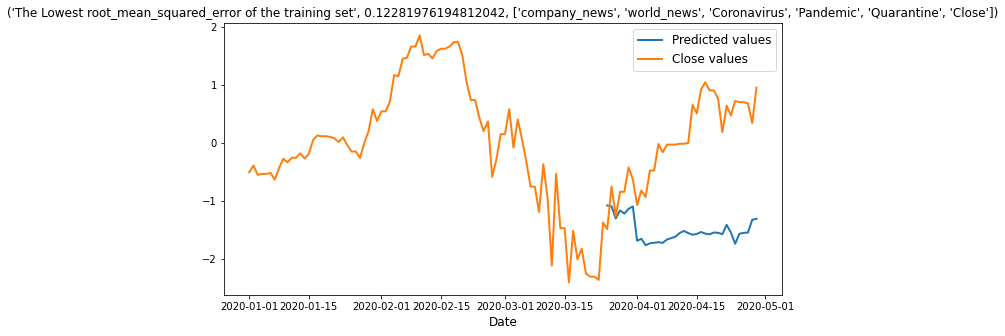

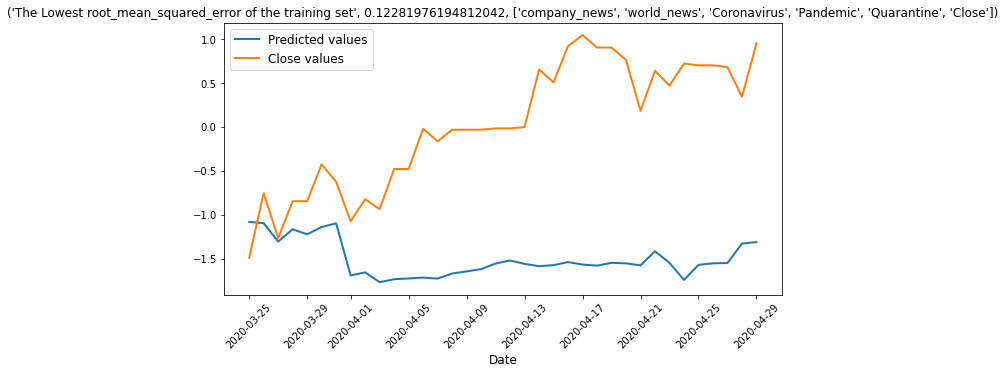

Root_mean_squared_error of the testing set:  1.7208769424332266
neg_mean_squared_error of the testing set:  -0.4250145160094105
mean_absolute_percentage_error of the testing set:  8130.534565872295
R2 score of the testing set:  -4.9040028312854504


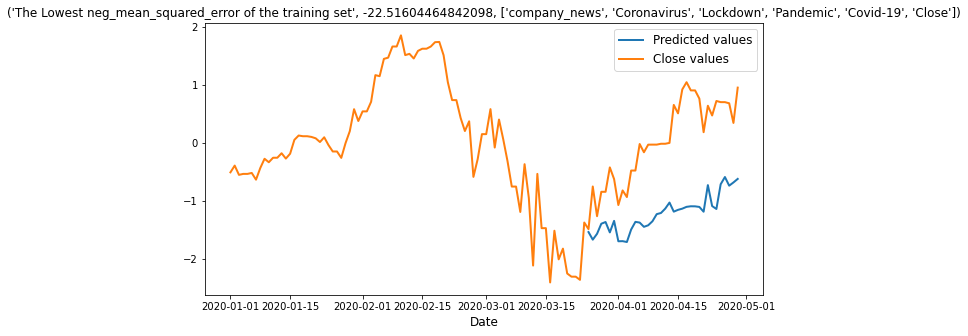

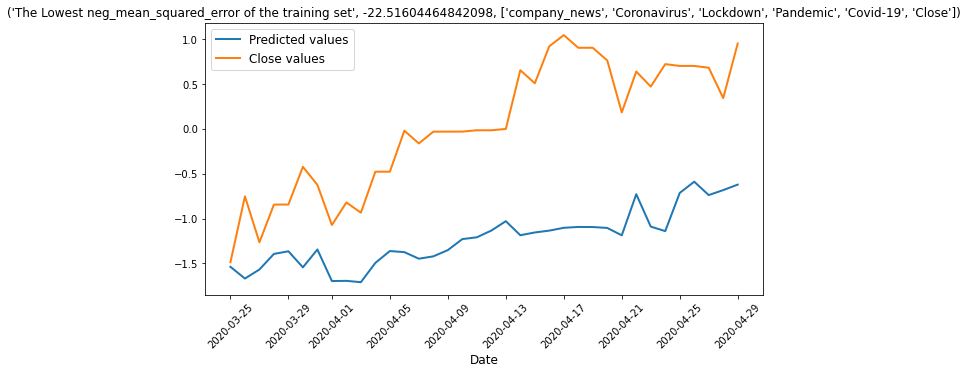

Root_mean_squared_error of the testing set:  1.3394010209665408
neg_mean_squared_error of the testing set:  -5.136214491226733
mean_absolute_percentage_error of the testing set:  5557.6673557002905
R2 score of the testing set:  -2.576581922424382


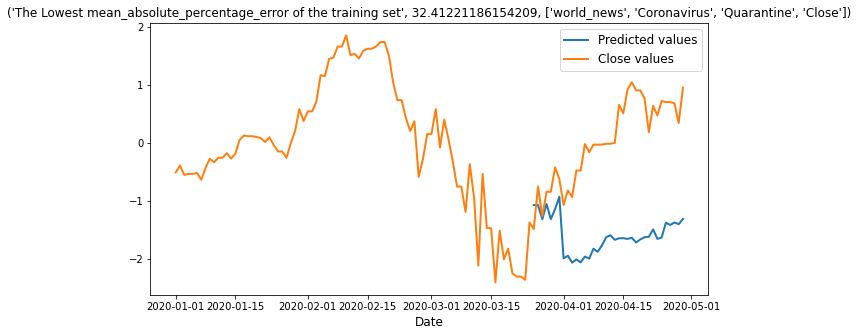

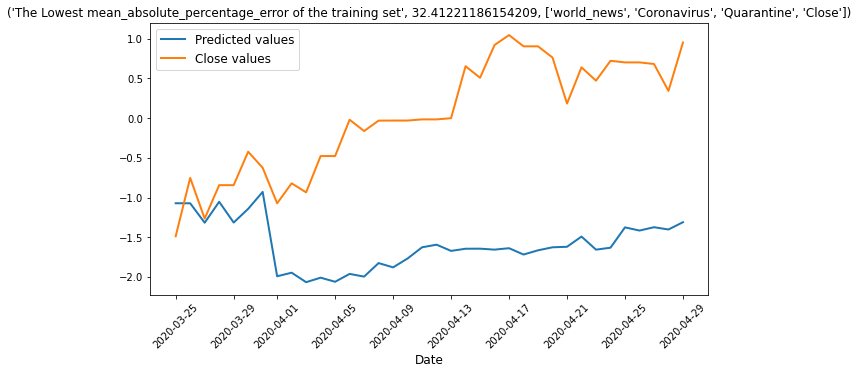

Root_mean_squared_error of the testing set:  1.7960413715385974
neg_mean_squared_error of the testing set:  -0.7822365007842362
mean_absolute_percentage_error of the testing set:  8746.74298885545
R2 score of the testing set:  -5.431016125036638


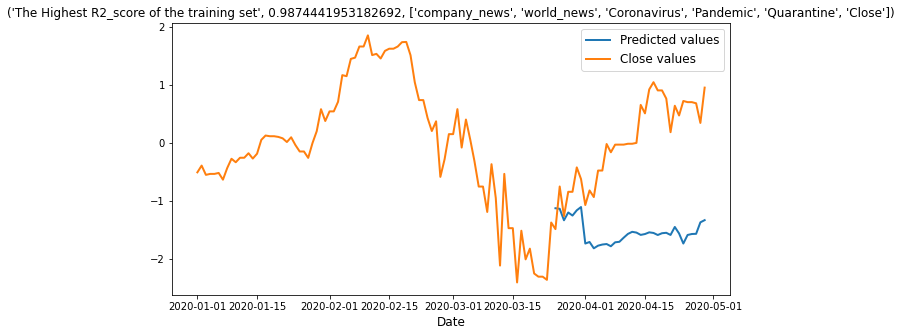

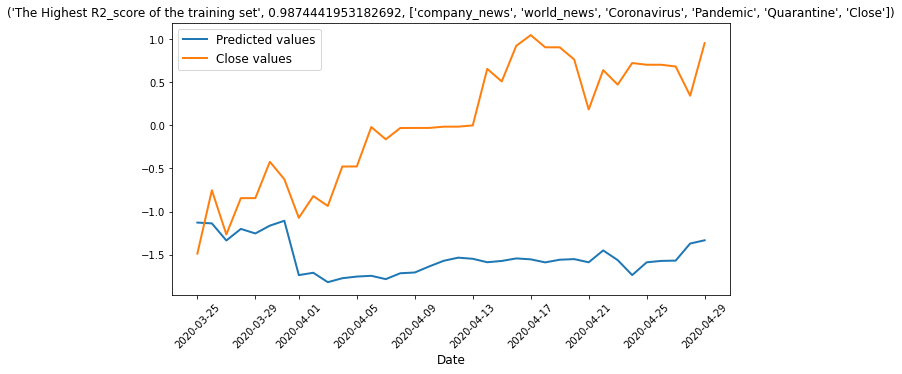

Root_mean_squared_error of the testing set:  1.7384664644050083
neg_mean_squared_error of the testing set:  -0.4250145160094105
mean_absolute_percentage_error of the testing set:  8113.359851165685
R2 score of the testing set:  -5.025312282755665


In [15]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

In [17]:
features_from_other_timewindows_based_on_features_importance = [[['company_trends','Lockdown','presidential election','Pandemic','Quarantine','world_news','company_news','Close'],"Zika"],
                                                         [['presidential election','Pandemic','company_trends','Close'],'Election 2012'],
                                                         [['zika','presidential election','Close'], 'Election 2016']]
# # Zika                   features_importance
# presidential election             0.212932
# Lockdown                          0.175207
# company_trends                    0.161623
# Pandemic                          0.115094
# Quarantine                        0.114997
# world_news                        0.112698
# company_news                      0.107450
# zika                              0.000000

# # Election 2012          features_importance
#                        features_importance
# Pandemic                          0.282572
# presidential election             0.264511
# company_trends                    0.190962
# Lockdown                          0.091221
# company_news                      0.089035
# world_news                        0.041382
# Quarantine                        0.040316

# # Election 2016          features_importance
# zika                              0.617577
# presidential election             0.210193
# Quarantine                        0.059076
# company_trends                    0.052109
# Lockdown                          0.021216
# world_news                        0.014365
# Pandemic                          0.013598
# company_news                      0.011866

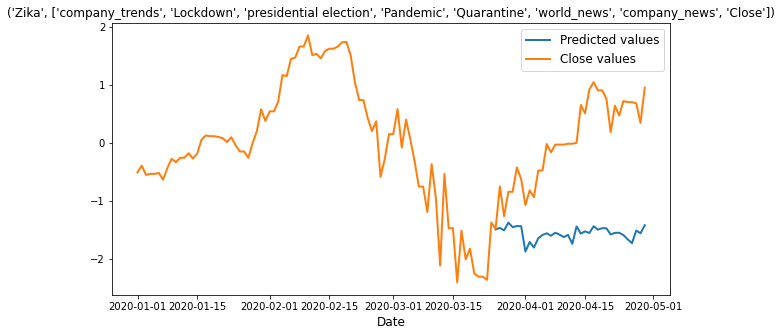

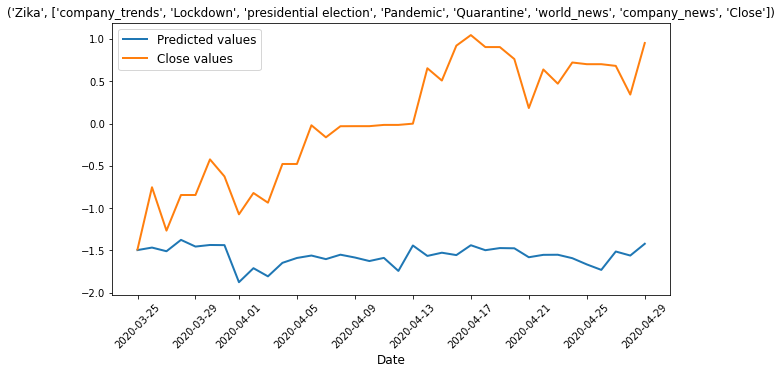

Root_mean_squared_error:  1.7293553189717268
neg_mean_squared_error:  -0.5508572679839218
mean_absolute_percentage_error:  7645.6824203705055
R2 score:  -4.9623215478702045


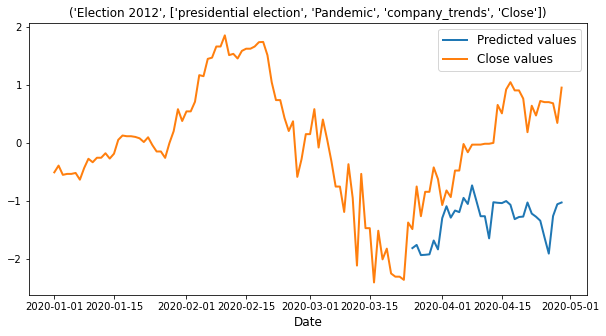

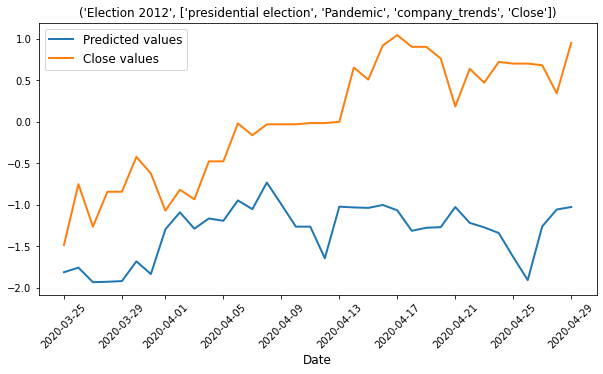

Root_mean_squared_error:  1.486510110870954
neg_mean_squared_error:  -8.500386718131626
mean_absolute_percentage_error:  5497.39150213388
R2 score:  -3.405372747609249


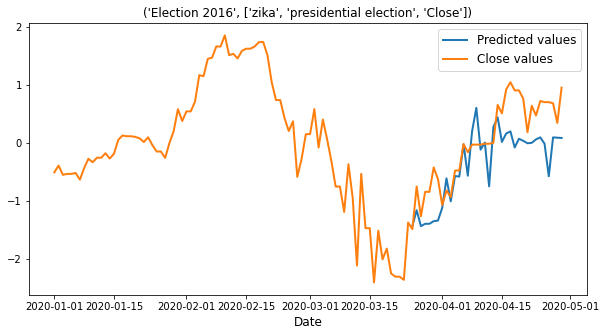

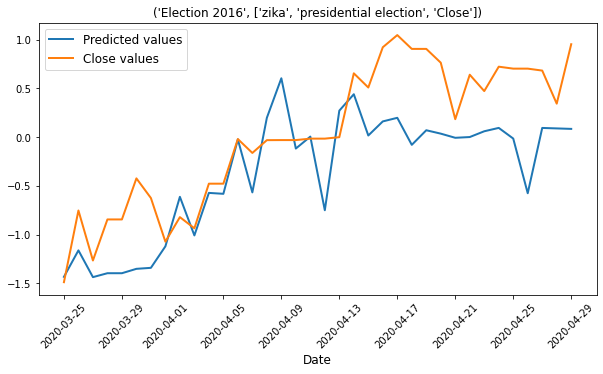

Root_mean_squared_error:  0.5674122848507807
neg_mean_squared_error:  -0.6117618663496701
mean_absolute_percentage_error:  1457.425300048374
R2 score:  0.3581339660127725


In [18]:
for k,i in enumerate(features_from_other_timewindows_based_on_features_importance):

    df_1 = std_df[i[0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.xticks(rotation=45)
    plt.show()
    
        # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score: ", R2_score)

# Zika

In [19]:
# removing covid_19, coronavirus features which have only 0s.
df = Zika[['company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
         'Close']]

In [20]:
df.index = pd.to_datetime(df.index)


In [21]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [22]:
cutIdx = int(len(std_df)*0.7)

In [23]:
X_train, X_test = std_df.drop('Close', axis=1)[:cutIdx], std_df.drop('Close', axis=1)[cutIdx:]
y_train, y_test = std_df['Close'][:cutIdx], std_df['Close'][cutIdx:]

model.fit(X_train,y_train)

features_importance = model.feature_importances_



features_importance = pd.DataFrame(data = features_importance, index =['company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        ], columns = ["features_importance"] )



print(features_importance.iloc[(-features_importance['features_importance'].abs()).argsort()])

                       features_importance
presidential election             0.213901
Lockdown                          0.175196
company_trends                    0.157212
Quarantine                        0.116091
world_news                        0.115772
Pandemic                          0.111098
company_news                      0.110730
zika                              0.000000


In [24]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [25]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [26]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [27]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [28]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

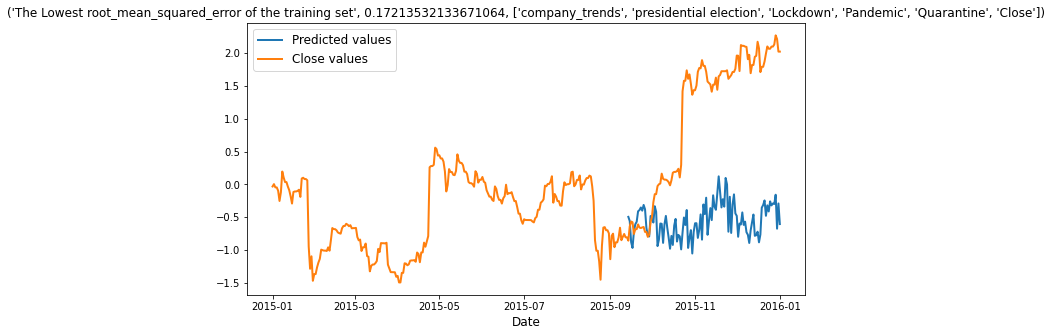

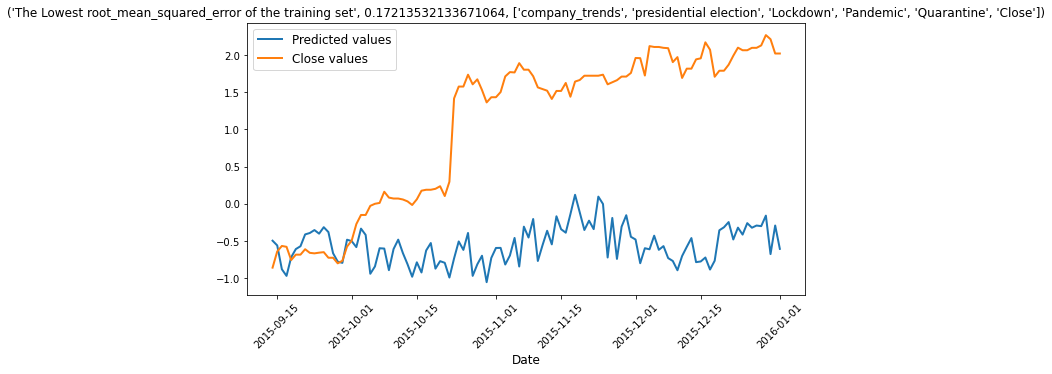

Root_mean_squared_error of the testing set:  1.8949054035779225
neg_mean_squared_error of the testing set:  -1.3328761855406037
mean_absolute_percentage_error of the testing set:  773.4351660392039
R2 score of the testing set:  -2.377972556056781


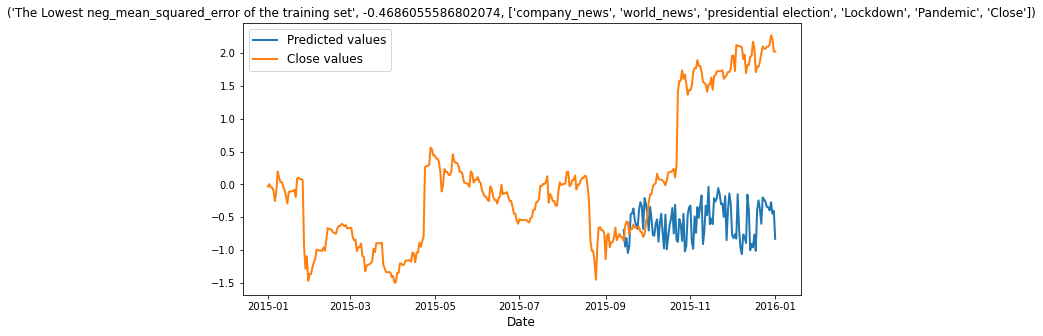

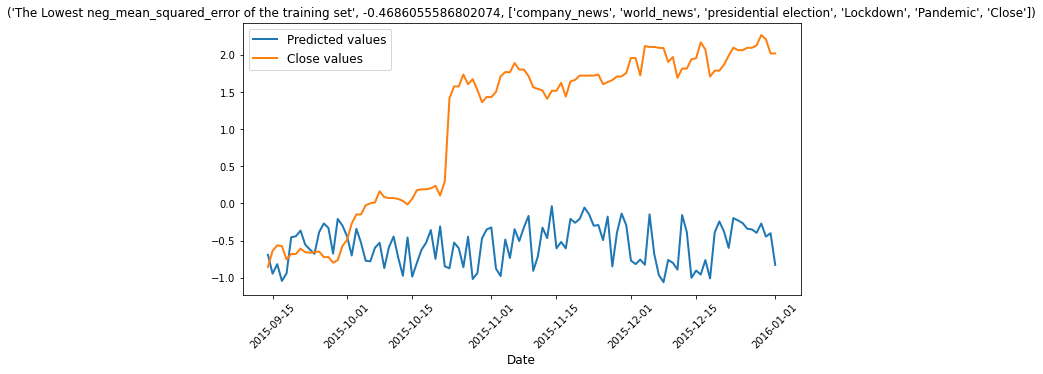

Root_mean_squared_error of the testing set:  1.9237319836040943
neg_mean_squared_error of the testing set:  -1.443156529948195
mean_absolute_percentage_error of the testing set:  707.5360337894939
R2 score of the testing set:  -2.4815303021638306


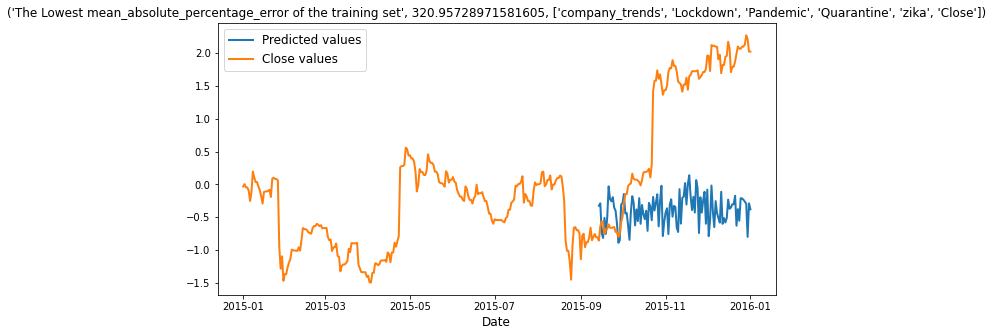

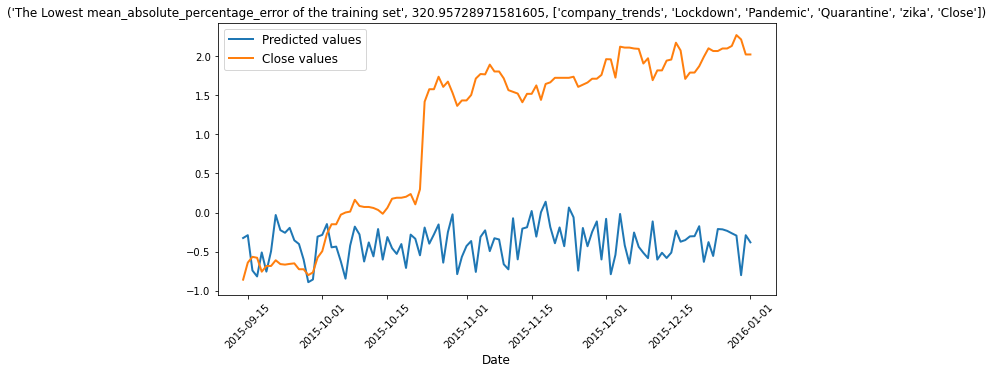

Root_mean_squared_error of the testing set:  1.7673155953894624
neg_mean_squared_error of the testing set:  -2.2214679656321334
mean_absolute_percentage_error of the testing set:  680.1352166374263
R2 score of the testing set:  -1.938388854752679


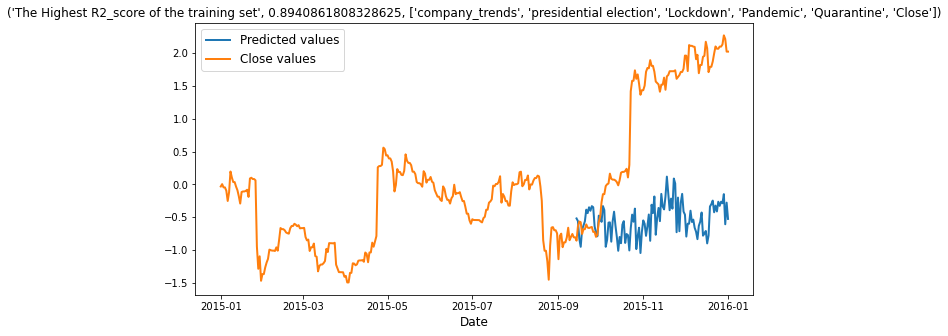

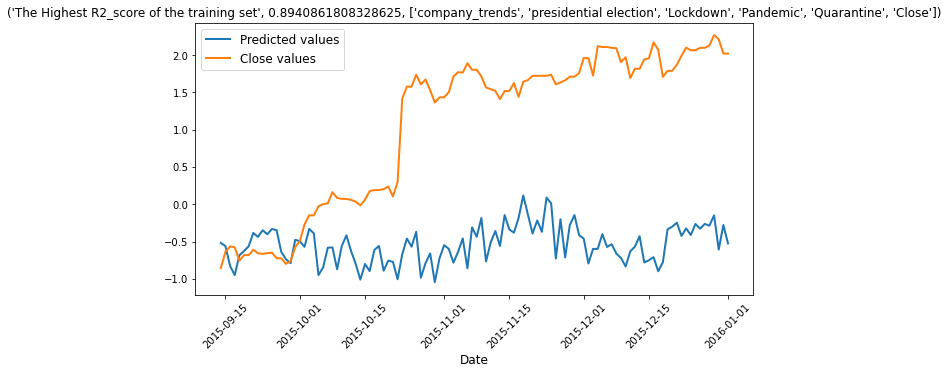

Root_mean_squared_error of the testing set:  1.8817823222459036
neg_mean_squared_error of the testing set:  -1.3328761855406037
mean_absolute_percentage_error of the testing set:  774.4974509984577
R2 score of the testing set:  -2.331346578998647


In [29]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2012

In [30]:
# removing covid_19, coronavirus, zika features which have only 0s.
df = election_2012[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
         'Close']]

In [31]:
df.index = pd.to_datetime(df.index)


In [32]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [33]:
cutIdx = int(len(std_df)*0.7)

In [34]:
X_train, X_test = std_df.drop('Close', axis=1)[:cutIdx], std_df.drop('Close', axis=1)[cutIdx:]
y_train, y_test = std_df['Close'][:cutIdx], std_df['Close'][cutIdx:]

model.fit(X_train,y_train)

features_importance = model.feature_importances_



features_importance = pd.DataFrame(data = features_importance, index =['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine'], columns = ["features_importance"] )



print(features_importance.iloc[(-features_importance['features_importance'].abs()).argsort()])

                       features_importance
Pandemic                          0.282134
presidential election             0.268580
company_trends                    0.189720
company_news                      0.090069
Lockdown                          0.087158
world_news                        0.042657
Quarantine                        0.039683


In [35]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [36]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [37]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [38]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [39]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

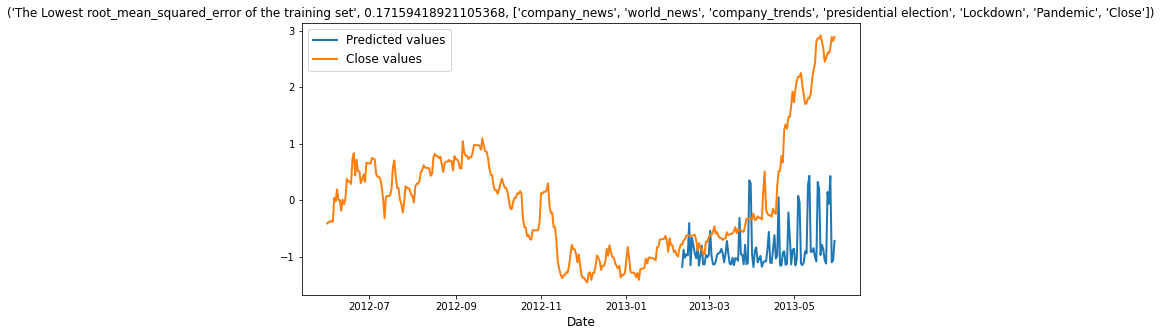

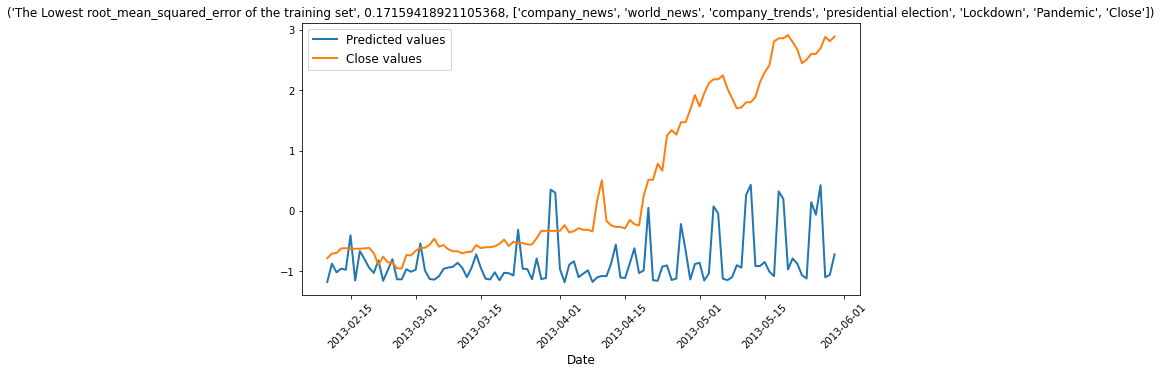

Root_mean_squared_error of the testing set:  1.7855108136711666
neg_mean_squared_error of the testing set:  -1.6400036608645023
mean_absolute_percentage_error of the testing set:  138.57868662173212
R2 score of the testing set:  -0.8642823496592413


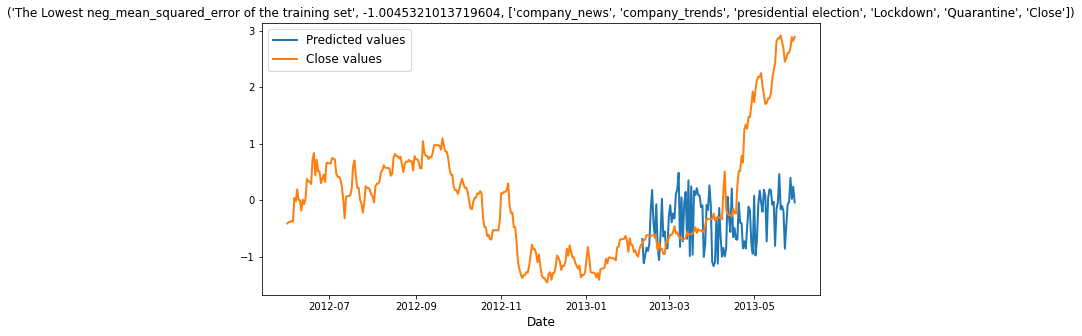

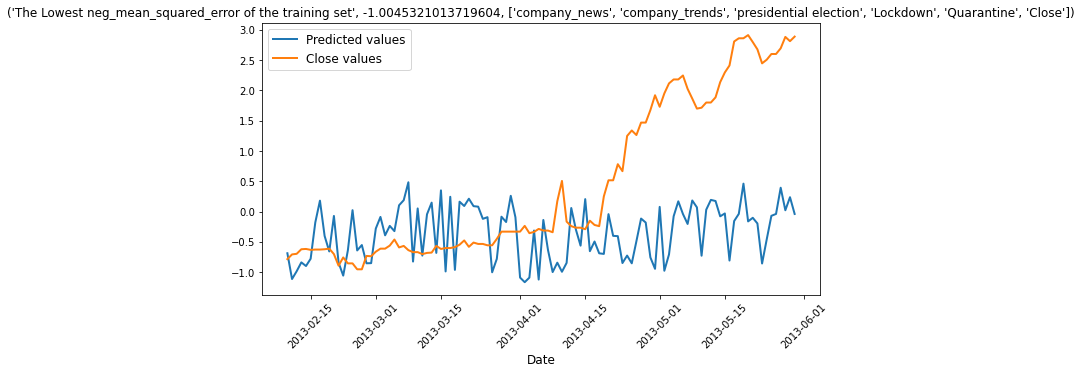

Root_mean_squared_error of the testing set:  1.5035302943162774
neg_mean_squared_error of the testing set:  -1.4672132538221638
mean_absolute_percentage_error of the testing set:  115.19976603603801
R2 score of the testing set:  -0.32193799244608146


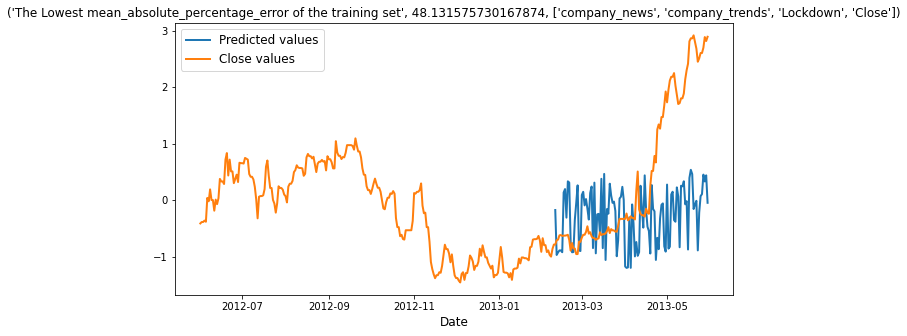

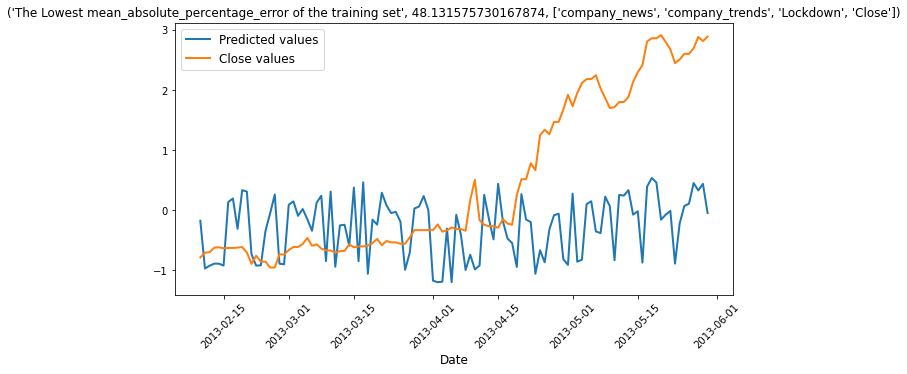

Root_mean_squared_error of the testing set:  1.4749483907965912
neg_mean_squared_error of the testing set:  -1.748298105993102
mean_absolute_percentage_error of the testing set:  116.73510462338044
R2 score of the testing set:  -0.27215598978315114


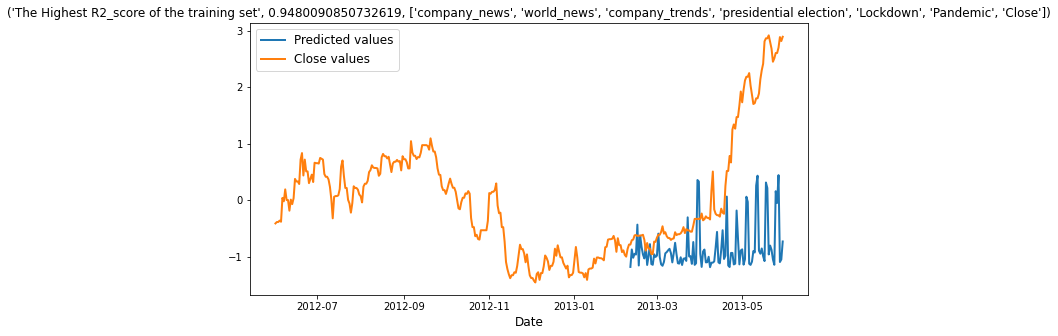

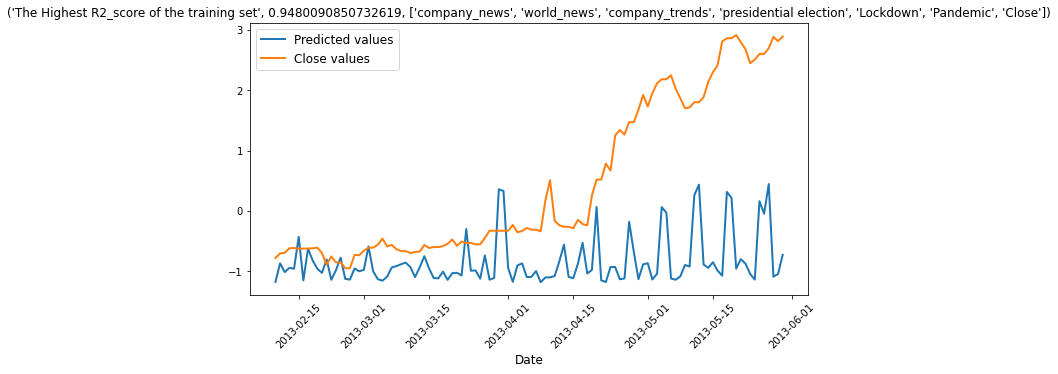

Root_mean_squared_error of the testing set:  1.7857147293980158
neg_mean_squared_error of the testing set:  -1.6400036608645023
mean_absolute_percentage_error of the testing set:  138.55313728335784
R2 score of the testing set:  -0.8647081977644604


In [40]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2016

In [41]:
# removing covid_19, coronavirus features which have only 0s.
df = election_2016[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'Close']]

In [42]:
df.index = pd.to_datetime(df.index)


In [43]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [44]:
cutIdx = int(len(std_df)*0.7)

In [45]:
X_train, X_test = std_df.drop('Close', axis=1)[:cutIdx], std_df.drop('Close', axis=1)[cutIdx:]
y_train, y_test = std_df['Close'][:cutIdx], std_df['Close'][cutIdx:]

model.fit(X_train,y_train)

features_importance = model.feature_importances_



features_importance = pd.DataFrame(data = features_importance, index =['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika'], columns = ["features_importance"] )



print(features_importance.iloc[(-features_importance['features_importance'].abs()).argsort()])

                       features_importance
zika                              0.620329
presidential election             0.209781
Quarantine                        0.055765
company_trends                    0.052673
Lockdown                          0.021694
world_news                        0.014149
Pandemic                          0.013509
company_news                      0.012100


In [46]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [47]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [48]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [49]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [50]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

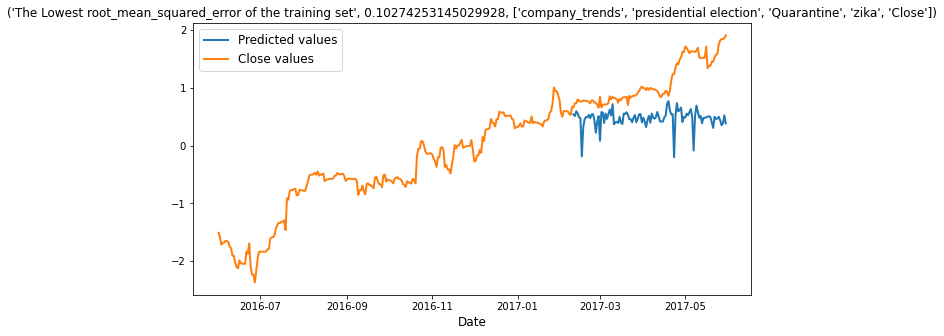

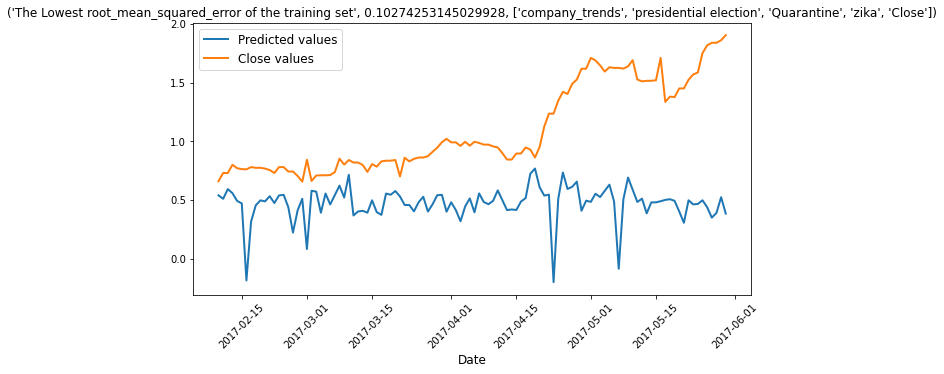

Root_mean_squared_error of the testing set:  0.7424183985452016
neg_mean_squared_error of the testing set:  -0.1281212080976452
mean_absolute_percentage_error of the testing set:  52.378056135537356
R2 score of the testing set:  -2.9391101015939234


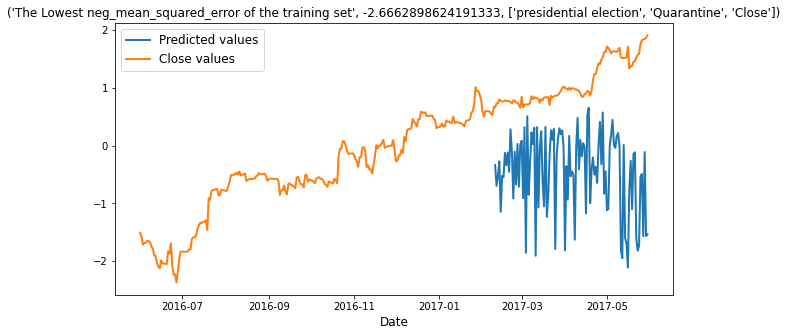

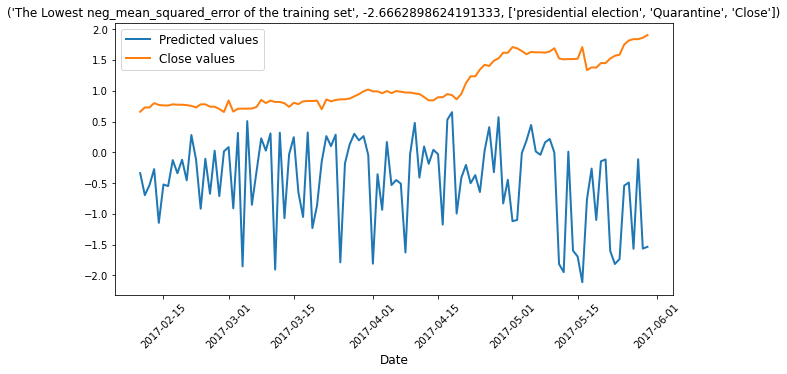

Root_mean_squared_error of the testing set:  1.7739015342031665
neg_mean_squared_error of the testing set:  -0.16151030759091528
mean_absolute_percentage_error of the testing set:  141.69860018292033
R2 score of the testing set:  -21.488458467971896


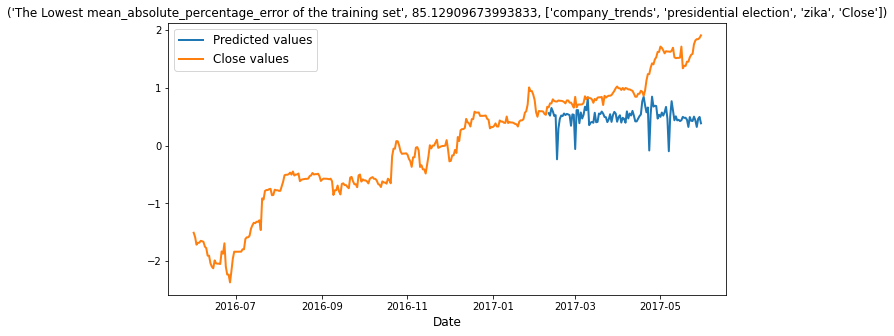

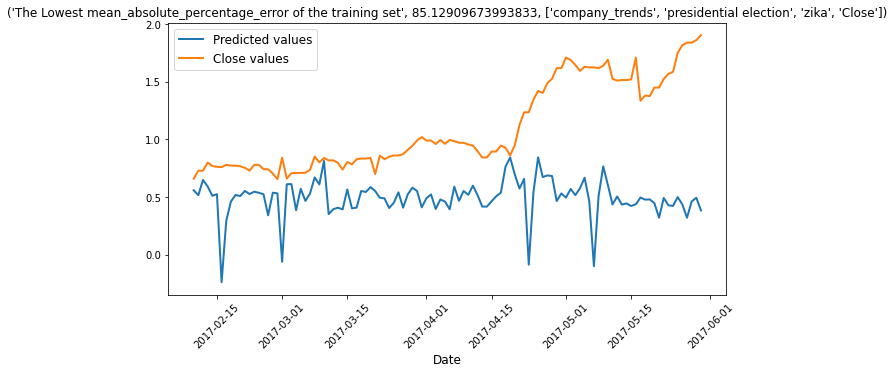

Root_mean_squared_error of the testing set:  0.7304522728464657
neg_mean_squared_error of the testing set:  -0.12262035772359658
mean_absolute_percentage_error of the testing set:  49.9650973562832
R2 score of the testing set:  -2.81315410663646


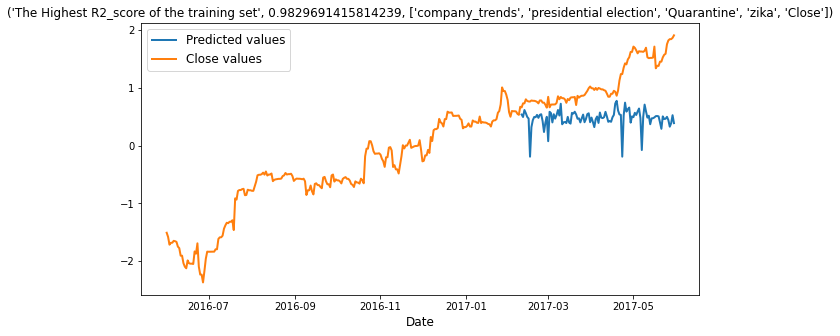

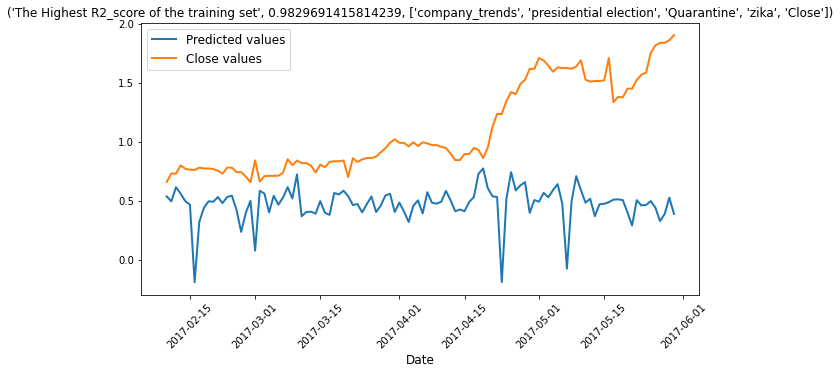

Root_mean_squared_error of the testing set:  0.7416520876039948
neg_mean_squared_error of the testing set:  -0.1281212080976452
mean_absolute_percentage_error of the testing set:  52.300226601413726
R2 score of the testing set:  -2.9309825408769306


In [51]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# 10 years

In [52]:
# removing covid_19, coronavirus features which have only 0s.
df = Company


In [53]:
df.index = pd.to_datetime(df.index)


In [54]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [55]:
cutIdx = int(len(std_df)*0.7)

In [56]:
X_train, X_test = std_df.drop('Close', axis=1)[:cutIdx], std_df.drop('Close', axis=1)[cutIdx:]
y_train, y_test = std_df['Close'][:cutIdx], std_df['Close'][cutIdx:]

model.fit(X_train,y_train)

features_importance = model.feature_importances_



features_importance = pd.DataFrame(data = features_importance, index =['company_news', 'world_news', 'company_trends', 'Coronavirus',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
       'Covid-19'], columns = ["features_importance"] )



print(features_importance.iloc[(-features_importance['features_importance'].abs()).argsort()])

                       features_importance
zika                              0.780046
Pandemic                          0.061347
presidential election             0.052534
Lockdown                          0.027491
company_trends                    0.026411
Quarantine                        0.020741
company_news                      0.019775
world_news                        0.011656
Coronavirus                       0.000000
Covid-19                          0.000000


In [57]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [58]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [59]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [60]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [61]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

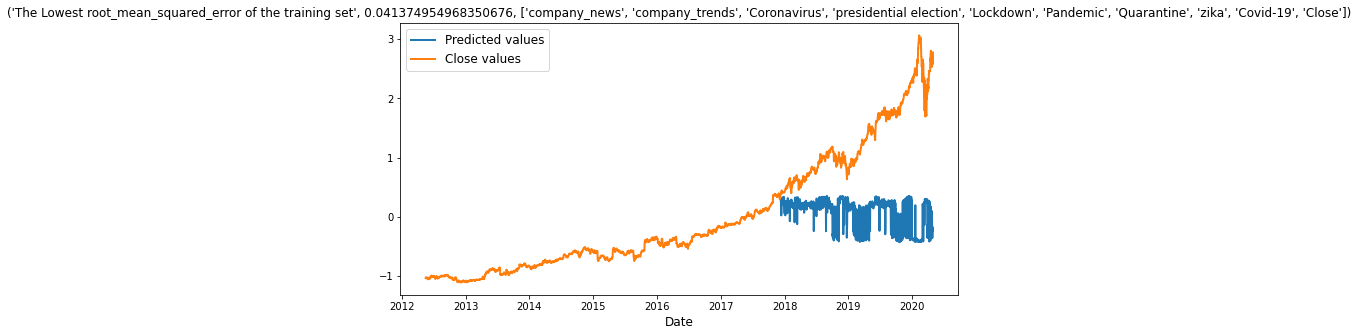

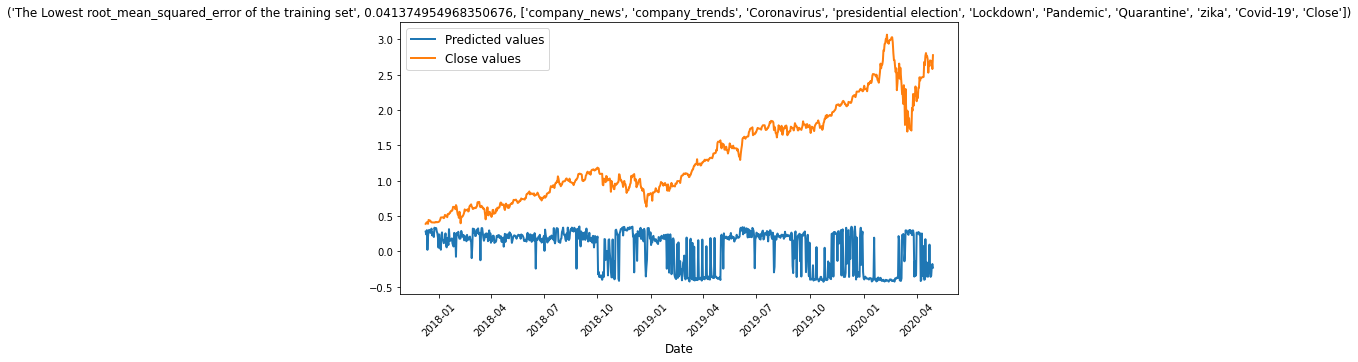

Root_mean_squared_error of the testing set:  1.5275684988822305
neg_mean_squared_error of the testing set:  -6.866826357881186
mean_absolute_percentage_error of the testing set:  89.91841537242645
R2 score of the testing set:  -4.42124433587739


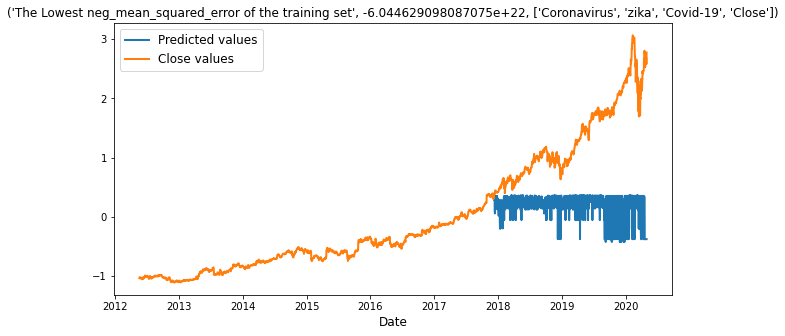

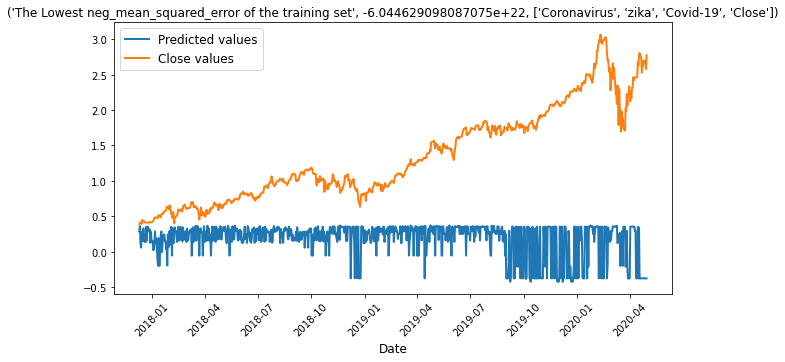

Root_mean_squared_error of the testing set:  1.3880936114355418
neg_mean_squared_error of the testing set:  -19.063854327541033
mean_absolute_percentage_error of the testing set:  80.75137523838352
R2 score of the testing set:  -3.4764640851984057


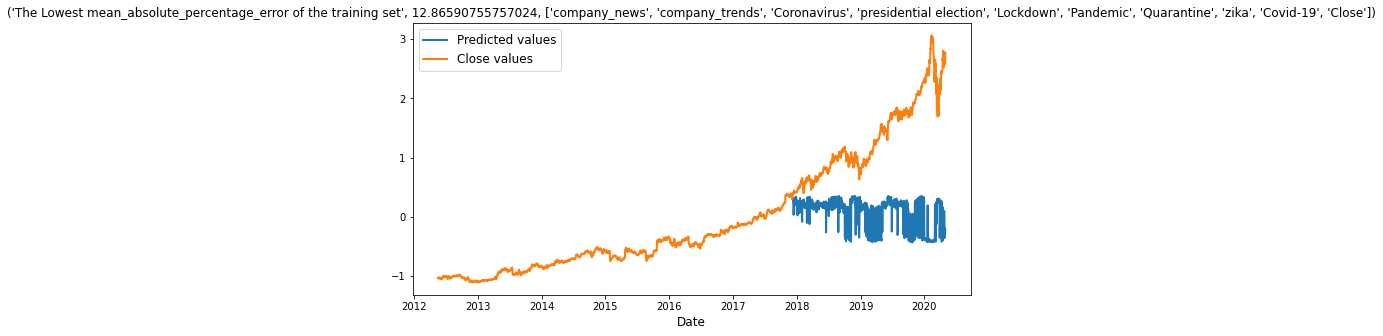

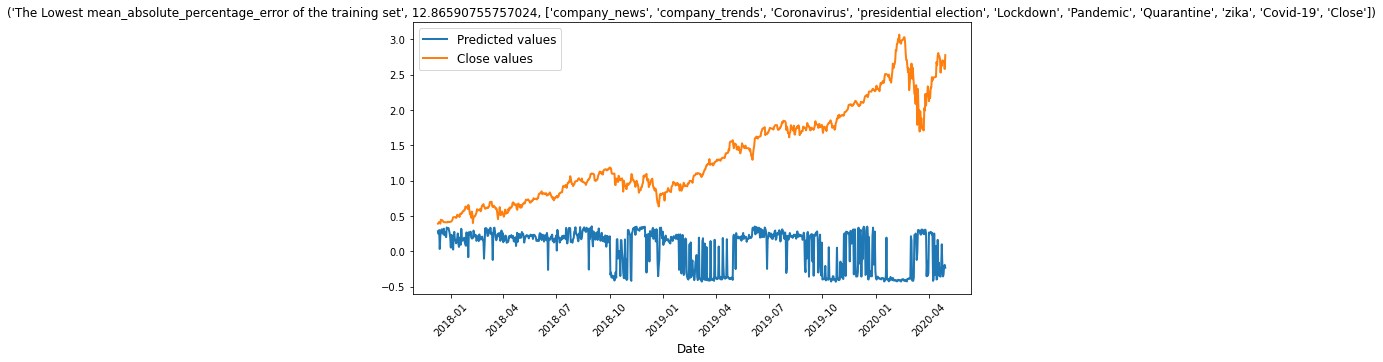

Root_mean_squared_error of the testing set:  1.5295096342840717
neg_mean_squared_error of the testing set:  -6.866826357881186
mean_absolute_percentage_error of the testing set:  90.09594791796904
R2 score of the testing set:  -4.43503102435542


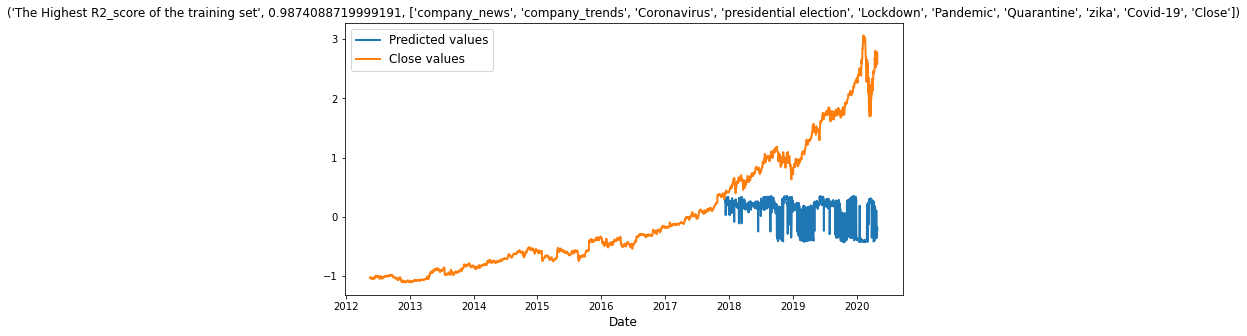

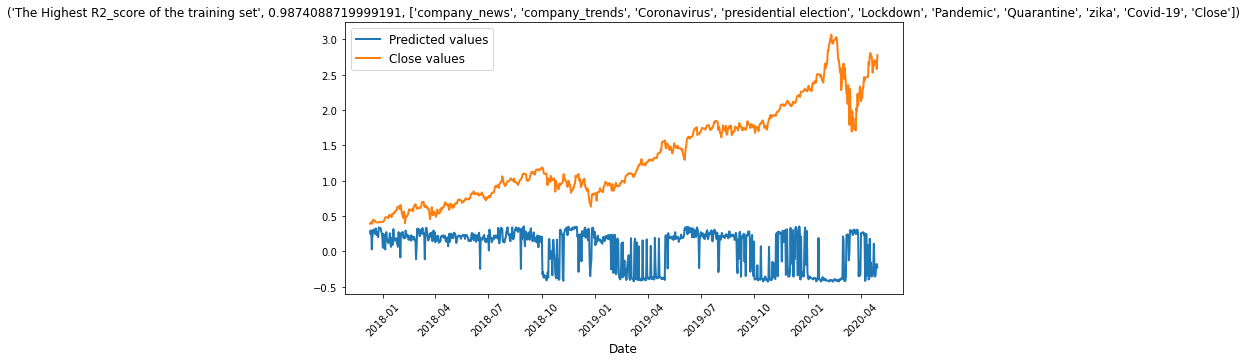

Root_mean_squared_error of the testing set:  1.5281555746277993
neg_mean_squared_error of the testing set:  -6.866826357881186
mean_absolute_percentage_error of the testing set:  89.95690679698923
R2 score of the testing set:  -4.425412126254534


In [62]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)